In [18]:
import random

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [19]:
# Read in data
words = open('names.txt', 'r').read().splitlines()

words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [20]:
# Build the vocabulary of characters and mappings to/from integers
chars = sorted(set(''.join(words)))
c_to_i = {c: i+1 for i, c in enumerate(chars)}
c_to_i['.'] = 0
i_to_c = {i: c for c, i in c_to_i.items()}
VOCAB_SIZE = len(i_to_c)

In [21]:
# Number of inputs prior to target character
BLOCK_SIZE = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * BLOCK_SIZE

        for ch in w + '.':
            target_idx = c_to_i[ch]
            X.append(context)
            Y.append(target_idx)

            # Slide context window over to next set of chars
            context = context[1:] + [target_idx]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [22]:
# Instantitate generator
g = torch.Generator().manual_seed(2147483647)

# Set hyper parameters
EMBEDDING_DIM = 10
INPUT_DIM = BLOCK_SIZE * EMBEDDING_DIM
HIDDEN_DIM = 64

# Create embedding matrix
C = torch.randn((VOCAB_SIZE, EMBEDDING_DIM),    generator=g)

# Create weight_1 & bias_1
W1 = torch.randn((INPUT_DIM, HIDDEN_DIM),       generator=g) * (5 / 3) / (INPUT_DIM ** 0.5)
b1 = torch.randn(HIDDEN_DIM,                    generator=g) * 0.1

# Create weight_2 & bias_2
W2 = torch.randn((HIDDEN_DIM, VOCAB_SIZE),      generator=g) * 0.1
b2 = torch.randn(VOCAB_SIZE,                    generator=g) * 0.1

# Batch norm parameters
bn_gain = torch.randn((1, HIDDEN_DIM),          generator=g) * 0.1 + 1.0
bn_bias = torch.randn((1, HIDDEN_DIM),          generator=g) * 0.1

# Require gradients
parameters = [C, W1, b1, W2, b2, bn_gain, bn_bias]
for p in parameters:
    p.requires_grad = True


In [23]:
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approx: {str(app):5s} | maxdiff: {maxdiff}')

In [24]:
# Training params
batch_size = 32
eps = 1e-5

# get batch
ixs = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
x_batch, y_batch = X_train[ixs], Y_train[ixs]

In [25]:
## Implement forward pass step-by-step so we can work through backprop below

# Get character embeddings
emb = C[x_batch]
# Concat embeddings
embcat = emb.view(emb.shape[0], -1)

# Linear layer 1
h_pre_bn = embcat @ W1 + b1

# Batch norm
bn_mean_i = (1 / batch_size) * h_pre_bn.sum(0, keepdim=True)
bn_diff = h_pre_bn - bn_mean_i
bn_diff_sq = bn_diff ** 2
bn_var = 1 / (batch_size - 1) * bn_diff_sq.sum(0, keepdim=True)
bn_var_inv = (bn_var + eps) ** -0.5
bn_raw = bn_diff * bn_var_inv
h_pre_act = bn_gain * bn_raw + bn_bias

# Non-linearity
h = torch.tanh(h_pre_act)

# Linear layer 2
logits = h @ W2 + b2

# Cross-entropy loss
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum ** -1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(batch_size), y_batch].mean() 

# Backward pass
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts_sum_inv, counts_sum, counts, 
          norm_logits, logit_maxes, logits, h, h_pre_act,
          bn_raw, bn_var_inv, bn_var, bn_diff_sq, bn_diff, bn_mean_i,
          h_pre_bn, embcat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(3.5571, grad_fn=<NegBackward0>)

In [119]:
# Derivative of loss w.r.t logprobs
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(batch_size), y_batch] = -1.0 / batch_size
cmp('logprobs', dlogprobs, logprobs)

# dloss / dprobs = (dlogprobs / dprobs) * (dloss / dloglprobs)
# dlogprobs / dprobs = 1 / probs
dprobs = (1.0 / probs) * dlogprobs
cmp('probs', dprobs, probs)

# dloss / dcounts_sum_inv = (dprobs / dcounts_sum_inv) * (dloss / dprobs)
# dprobs / dcounts_sum_inv = counts
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

# dloss / dcounts_sum = (dcounts_sum_inv / dcounts_sum) * (dloss / dcounts_sum_inv)
# dcounts_sum_inv / dcounts_sum = -counts_sum ** -2
dcounts_sum = (-counts_sum ** -2) * dcounts_sum_inv
cmp('counts_sum', dcounts_sum, counts_sum)

# dloss / dcounts = (dprobs / dcounts) * (dloss / dprobs) + (dcounts_sum / dcounts) * (dloss / dcounts_sum)
# dprobs / dcounts = counts_sum_inv
# dcounts_sum / dcounts = ones_lke(counts)
dcounts = (counts_sum_inv * dprobs) + (torch.ones_like(counts) * dcounts_sum)
cmp('counts', dcounts, counts)

# dloss / dnorm_logits = (dcounts / dnorm_logits) * (dloss / dcounts)
# dcounts / dnorm_logits = counts
dnorm_logits = counts * dcounts
cmp('norm_logits', dnorm_logits, norm_logits)

# dloss / dlogit_maxes = (dnorm_logits / dlogit_maxes) * (dloss / dnorm_logits)
# dnorm_logits / dlogit_maxes = -1
dlogit_maxes = (-1 * dnorm_logits).sum(1, keepdim=True)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
# cmp('dlogit_maxes', torch.zeros_like(logit_maxes), logit_maxes) # include this test b/c dlogit_maxes should be approx 0

# dloss / dlogits = (dnorm_logits / dlogits) * (dloss / dnorm_logits) + (dlogit_maxes / dlogits) * (dloss / dlogit_maxes)
# dnorm_logits / dlogits = 1
# dlogit_maxes / dlogits = zeros_like(logits) w/ 1s at the max indices
dlogits = torch.zeros_like(logits)
dlogits[range(batch_size), logits.max(1, keepdim=True).indices.view(-1)] = 1
dlogits = dlogits * dlogit_maxes + dnorm_logits
cmp('logits', dlogits, logits)

# dloss / dh = (dloss / dlogits) @ W2.T
dh = dlogits @ W2.T
cmp('h', dh, h)

# dloss / dW2 = h.T @ (dloss / dlogits)
dW2 = h.T @ dlogits
cmp('W2', dW2, W2)

# dloss / db2 = (dloss / dlogits).sum(0)
db2 = dlogits.sum(0)
cmp('b2', db2, b2)

# dh_pre_act = (dh / dh_pre_act) * (dloss / dh)
# dh / dh_pre_act = 1 - h ** 2
dh_pre_act = (1 - h ** 2) * dh 
cmp('h_pre_act', dh_pre_act, h_pre_act)

dbn_gain = (bn_raw * dh_pre_act).sum(0, keepdim=True)
cmp('bn_gain', dbn_gain, bn_gain)

dbn_raw = bn_gain * dh_pre_act
cmp('bn_raw', dbn_raw, bn_raw)

dbn_bias = dh_pre_act.sum(0, keepdim=True)
cmp('bn_bias', dbn_bias, bn_bias)

# dloss / dbn_var_inv = (dbn_raw / dbn_var_inv) * (dbn_loss / dbn_raw)
# dbn_raw / dbn_var_inv = bn_diff.sum(0, keepdim=True)
dbn_var_inv = (bn_diff * dbn_raw).sum(0, keepdim=True)
cmp('bn_var_inv', dbn_var_inv, bn_var_inv)

# dloss / dbn_var = (dbn_var_inv / dbn_var) * (dloss / dbn_var_inv)
# dbn_var_inv / dbn_var = -0.5 * (bn_var + eps) ** -1.5
dbn_var = (-0.5 * ((bn_var + eps) ** -1.5)) * dbn_var_inv
cmp('bn_var', dbn_var, bn_var)

# dloss / dbn_diff_sq  = (dbn_var / dbn_diff_sq) * (dloss / dbn_var)
# dbn_var / dbn_diff_sq = ones_like(bn_diff_sq) * (1 / (batch_size - 1))
dbn_diff_sq = (torch.ones_like(bn_diff_sq) * (1 / (batch_size - 1))) * dbn_var
cmp('bn_diff_sq', dbn_diff_sq, bn_diff_sq)

# dloss / dbn_diff = (dbn_raw / dbn_diff) * (dloss / dbn_raw) + (dbn_diff_sq / dbn_diff) * (dloss / dbn_diff_sq)
# dbn_raw / dbn_diff = bn_var_inv
# dbn_diff_sq / dbn_diff = 2 * bn_diff
dbn_diff = bn_var_inv * dbn_raw + 2 * bn_diff * dbn_diff_sq
cmp('bn_diff', dbn_diff, bn_diff)

# dloss / dbn_mean_i = (dbn_diff / dbn_mean_i) * (dloss / dbn_diff)
# dbn_diff / dbn_mean_i = -1
dbn_mean_i = (-1 * dbn_diff).sum(0, keepdim=True)
cmp('bn_mean_i', dbn_mean_i, bn_mean_i)

# dloss / dh_pre_bn = (dbn_mean_i / dh_pre_bn) * (dloss / dbn_mean_i) + (dbn_diff / dh_pre_bn) * (dloss / dbn_diff)
# dbn_mean_i / dh_pre_bn = ones_like(h_pre_bn) * (1 / batch_size)
# dbn_diff / dh_pre_bn = 1
dh_pre_bn = torch.ones_like(h_pre_bn) * (1 / batch_size) * dbn_mean_i + dbn_diff
cmp('h_pre_bn', dh_pre_bn, h_pre_bn)

dembcat = dh_pre_bn @ W1.T
cmp('embcat', dembcat, embcat)

dW1 = embcat.T @ dh_pre_bn
cmp('W1', dW1, W1)

db1 = dh_pre_bn.sum(0)
cmp('b1', db1, b1)

# embcat = just a reshaping, so in the backward pass, we just undo the transformation
# dloss / demb = dembcat.view(emb.shape)
demb = dembcat.view(emb.shape)
cmp('emb', demb, emb)

# emb = just an indexing, so we just accumulate the gradients for each item that is selected from C
dC = torch.zeros_like(C)
for k in range(x_batch.shape[0]):
    for j in range(x_batch.shape[1]):
        idx = x_batch[k, j]
        dC[idx] += demb[k, j]
cmp('C', dC, C)

logprobs        | exact: True  | approx: True  | maxdiff: 0.0
probs           | exact: True  | approx: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approx: True  | maxdiff: 0.0
counts_sum      | exact: True  | approx: True  | maxdiff: 0.0
counts          | exact: True  | approx: True  | maxdiff: 0.0
norm_logits     | exact: True  | approx: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approx: True  | maxdiff: 0.0
logits          | exact: True  | approx: True  | maxdiff: 0.0
h               | exact: True  | approx: True  | maxdiff: 0.0
W2              | exact: True  | approx: True  | maxdiff: 0.0
b2              | exact: True  | approx: True  | maxdiff: 0.0
h_pre_act       | exact: True  | approx: True  | maxdiff: 0.0
bn_gain         | exact: True  | approx: True  | maxdiff: 0.0
bn_raw          | exact: True  | approx: True  | maxdiff: 0.0
bn_bias         | exact: True  | approx: True  | maxdiff: 0.0
bn_var_inv      | exact: True  | approx: True  | maxdiff: 0.0
bn_var  

In [131]:
## faster backward pass from loss to dlogits
## gradient derived mathematically, = softmax at all *incorrect* indices, = softmax - 1 at all *correct* indices

# compute softmax
dlogits = F.softmax(logits, 1)

# subtract one at all the correct indices
dlogits[range(batch_size), y_batch] -= 1

# get average for batch
dlogits /= batch_size

cmp('logits', dlogits, logits)

logits          | exact: False | approx: True  | maxdiff: 5.122274160385132e-09


In [134]:
## faster backward pass from dh_pre_bn to dh_pre_act
## gradient derived mathematically (non-trivial formula)

dh_pre_bn = (bn_gain * bn_var_inv / batch_size) * ((batch_size * dh_pre_act) - dh_pre_act.sum(0) - ((batch_size / (batch_size - 1)) * bn_raw * (dh_pre_act * bn_raw).sum(0)))

cmp('h_pre_bn', dh_pre_bn, h_pre_bn)

h_pre_bn        | exact: False | approx: True  | maxdiff: 9.313225746154785e-10


In [144]:
# Recreate neural net, use manually-implemented backprop

# Instantitate generator
g = torch.Generator().manual_seed(2147483647)

# Set hyper parameters
EMBEDDING_DIM = 10
INPUT_DIM = BLOCK_SIZE * EMBEDDING_DIM
HIDDEN_DIM = 64

# Create embedding matrix
C = torch.randn((VOCAB_SIZE, EMBEDDING_DIM),    generator=g)

# Create weight_1 & bias_1
W1 = torch.randn((INPUT_DIM, HIDDEN_DIM),       generator=g) * (5 / 3) / (INPUT_DIM ** 0.5)
b1 = torch.randn(HIDDEN_DIM,                    generator=g) * 0.1

# Create weight_2 & bias_2
W2 = torch.randn((HIDDEN_DIM, VOCAB_SIZE),      generator=g) * 0.1
b2 = torch.randn(VOCAB_SIZE,                    generator=g) * 0.1

# Batch norm parameters
bn_gain = torch.randn((1, HIDDEN_DIM),          generator=g) * 0.1 + 1.0
bn_bias = torch.randn((1, HIDDEN_DIM),          generator=g) * 0.1

# Require gradients
parameters = [C, W1, b1, W2, b2, bn_gain, bn_bias]
for p in parameters:
    p.requires_grad = True

max_steps = 200000
batch_size = 32
eps = 1e-5
losses = []

with torch.no_grad():
    for i in range(max_steps):
        # get batch
        ixs = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
        x_batch, y_batch = X_train[ixs], Y_train[ixs]

        # Get character embeddings
        emb = C[x_batch]
        # Concat embeddings
        embcat = emb.view(emb.shape[0], -1)

        # Linear layer 1
        h_pre_bn = embcat @ W1 + b1

        # Batch norm
        bn_mean = h_pre_bn.mean(0, keepdim=True)
        bn_var = h_pre_bn.var(0, keepdim=True, unbiased=True)
        bn_var_inv = (bn_var + eps) ** -0.5
        bn_raw = (h_pre_bn - bn_mean) * bn_var_inv
        h_pre_act = bn_gain * bn_raw + bn_bias

        # Non-linearity
        h = torch.tanh(h_pre_act)

        # Linear layer 2
        logits = h @ W2 + b2

        # Cross-entropy loss
        loss = F.cross_entropy(logits, y_batch)

        for p in parameters:
            p.grad = None
        # loss.backward()

        ### MANUAL BACKPROP

        # Initialize gradient containers
        dC = dW1 = db1 = dW2 = db2 = dbn_gain = dbn_bias = None
        grads = [dC, dW1, db1, dW2, db2, dbn_gain, dbn_bias]

        dlogits = F.softmax(logits, 1)
        dlogits[range(batch_size), y_batch] -= 1
        dlogits /= batch_size

        dh = dlogits @ W2.T
        dW2 = h.T @ dlogits
        db2 = dlogits.sum(0)
        
        dh_pre_act = (1 - h ** 2) * dh

        dbn_gain = (bn_raw * dh_pre_act).sum(0, keepdim=True)
        dbn_bias = dh_pre_act.sum(0, keepdim=True)
        dh_pre_bn = (bn_gain * bn_var_inv / batch_size) * ((batch_size * dh_pre_act) - dh_pre_act.sum(0) - ((batch_size / (batch_size - 1)) * bn_raw * (dh_pre_act * bn_raw).sum(0)))

        dembcat = dh_pre_bn @ W1.T
        dW1 = embcat.T @ dh_pre_bn
        db1 = dh_pre_bn.sum(0)
        demb = dembcat.view(emb.shape)

        dC = torch.zeros_like(C)
        for k in range(x_batch.shape[0]):
            for j in range(x_batch.shape[1]):
                idx = x_batch[k, j]
                dC[idx] += demb[k, j]
        
        grads = [dC, dW1, db1, dW2, db2, dbn_gain, dbn_bias]
        
        # Update step
        lr = 0.1 if i < 100000 else 0.01
        for p, grad in zip(parameters, grads):
            # p.data += -lr * p.grad
            p.data += -lr * grad

        if i % 10000 == 0:
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        losses.append(loss.item())

        # if i >= 100:
        #     break    

      0/ 200000: 3.5571
  10000/ 200000: 2.1192
  20000/ 200000: 2.2414
  30000/ 200000: 2.3388
  40000/ 200000: 1.7104
  50000/ 200000: 2.0929
  60000/ 200000: 2.2691
  70000/ 200000: 1.9705
  80000/ 200000: 2.1847
  90000/ 200000: 2.3497
 100000/ 200000: 2.3924
 110000/ 200000: 2.2201
 120000/ 200000: 2.2079
 130000/ 200000: 1.7637
 140000/ 200000: 1.9729
 150000/ 200000: 2.5317
 160000/ 200000: 1.7812
 170000/ 200000: 2.4883
 180000/ 200000: 1.8456
 190000/ 200000: 2.1386


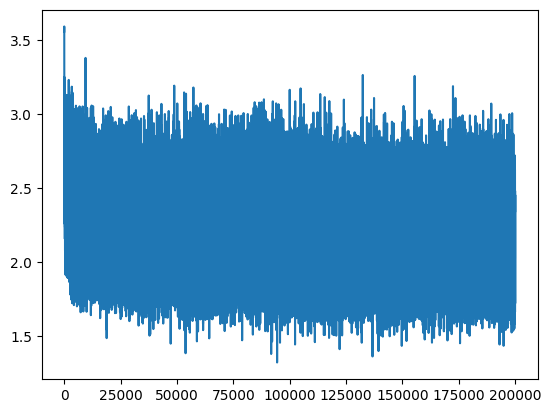

In [145]:
plt.plot(range(len(losses)), losses)

In [146]:
# Generate names
generator = torch.Generator().manual_seed(2147483647 + 10)
    
for _ in range(20):
    
    out = []
    context = [0] * BLOCK_SIZE # initialize with all ...
    while True:
      # forward pass
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      h_pre_act = embcat @ W1 + b1
      h_pre_act = bn_gain * (h_pre_act - bn_mean) * (bn_var + 1e-5)**-0.5 + bn_bias
      h = torch.tanh(h_pre_act) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(i_to_c[i] for i in out))

deviaa.
jacio.
ahiley.
nai.
kair.
lise.
rani.
theryn.
macally.
skylynn.
hadrelino.
karycooguna.
danie.
niia.
jonater.
can.
mel.
avers.
arean.
nelina.
